# 🚀 DDIM (Denoising Diffusion Implicit Models) from Scratch

**Paper**: [Denoising Diffusion Implicit Models (2010.02502)](https://arxiv.org/abs/2010.02502)  
**Authors**: Jiaming Song, Chenlin Meng, Stefano Ermon (Stanford, 2020)

---

## 🎯 DDPM vs DDIM: Key Differences

| Aspect | DDPM | DDIM |
|--------|------|------|
| **Process** | Markovian | **Non-Markovian** |
| **Sampling Steps** | All T (e.g., 1000) | Subset S (e.g., 50) |
| **Speed** | Slow | **10-50x faster** |
| **Determinism** | Always stochastic | **Can be deterministic (η=0)** |
| **Training** | L_simple | **Same L_simple** |

**Key Insight**: DDIM changes the *joint* distribution but keeps same *marginals*, so training is identical!

---

## 1. Environment Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import time

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


---

## 2. DDPM Recap

### 2.1 Forward Process (Markovian)

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t \mathbf{I})$$

**Closed form**:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})$$

### 2.2 DDPM Limitation

Must sample through **all T steps** (typically T=1000) sequentially. This is SLOW! ⏳

---

## 3. DDIM's Key Innovation

### Non-Markovian Process

**DDPM is Markovian**: $q(x_{t-1} | x_t, x_0) = q(x_{t-1} | x_t)$
- Can only go $x_t \rightarrow x_{t-1}$ (one step)
- Must iterate through ALL T timesteps

**DDIM is Non-Markovian**: $q_\sigma(x_{t-1} | x_t, x_0) \neq q_\sigma(x_{t-1} | x_t)$
- Conditions on $x_0$ (clean image)!
- Can jump from $x_t \rightarrow x_s$ for any $s < t$
- Use subset of timesteps: $S \ll T$ (e.g., 50 vs 1000)

**Result**: **20x speedup** with minimal quality loss!

---

## 4. The DDIM Sampling Equation (Equation 12)

**Most important equation in DDIM paper**:

$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \underbrace{\left( \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}} \right)}_{\text{predicted } x_0} + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot \epsilon_\theta(x_t, t) + \sigma_t \epsilon_t$$

Where:
- $\epsilon_\theta(x_t, t)$ = predicted noise from neural network
- $\epsilon_t \sim \mathcal{N}(0, \mathbf{I})$ = fresh random noise
- $\sigma_t$ = controls stochasticity (**key parameter!**)

### The η (Eta) Parameter

$$\sigma_t = \eta \cdot \sqrt{\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}} \cdot \sqrt{1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}}}$$

- **η=0**: $\sigma_t = 0$ → **Deterministic DDIM**
- **η=1**: $\sigma_t = \tilde{\beta}_t$ → **Recovers DDPM**

---

## 4.1 Detailed Derivation of Equation 12

### 📌 Starting Point: Closed Form of Forward Process

We already know from the forward process:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon_t$$

Solving for $x_0$:

$$x_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_t}{\sqrt{\bar{\alpha}_t}}$$

**Key insight**: Our model $\epsilon_\theta(x_t, t)$ predicts $\epsilon_t$, so we can predict $x_0$!

$$\hat{x}_0 = \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}}$$

### 🔄 Step 1: Reverse the Forward Process

**Forward process** (what we know):
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon_t$$

**Reverse process** (what we want):
$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{1-\bar{\alpha}_{t-1}} \epsilon_{t-1}$$

**Problem**: We don't know $x_0$ or $\epsilon_{t-1}$!

**Solution**:
1. Predict $\hat{x}_0$ from $x_t$ and $\epsilon_\theta(x_t, t)$
2. Connect $\epsilon_{t-1}$ with $\epsilon_\theta(x_t, t)$

### 🎯 Step 2: DDIM's Core Idea

DDIM proposes the following form:

$$x_{t-1} = \underbrace{\sqrt{\bar{\alpha}_{t-1}} \hat{x}_0}_{\text{Component 1: Predicted clean image}} + \underbrace{\sqrt{1-\bar{\alpha}_{t-1}-\sigma_t^2} \cdot \epsilon_\theta(x_t, t)}_{\text{Component 2: Direction}} + \underbrace{\sigma_t \epsilon_t}_{\text{Component 3: Noise}}$$

**Why this structure?**

1. **Component 1**: $\sqrt{\bar{\alpha}_{t-1}} \hat{x}_0$
   - Follows the mean structure of forward process
   - "How much clean image should remain at timestep $t-1$?"

2. **Component 2**: $\sqrt{1-\bar{\alpha}_{t-1}-\sigma_t^2} \cdot \epsilon_\theta(x_t, t)$
   - Maintains noise direction
   - Special coefficient: **To match variance!**

3. **Component 3**: $\sigma_t \epsilon_t$
   - Additional randomness
   - When $\sigma_t = 0$ → deterministic!

### 📊 Step 3: Matching the Variance

**Important constraint**: Variance of $x_{t-1}$ must match the forward process!

From forward process:
$$\text{Var}(x_{t-1}|x_0) = 1 - \bar{\alpha}_{t-1}$$

From DDIM (sum of variances from each component):
$$\underbrace{0}_{\text{Component 1 is deterministic}} + \underbrace{(1-\bar{\alpha}_{t-1}-\sigma_t^2) \cdot \|\epsilon_\theta\|^2}_{\text{Component 2}} + \underbrace{\sigma_t^2}_{\text{Component 3}}$$

Since $\|\epsilon_\theta\|^2 \approx 1$ (variance of noise):

$$(1-\bar{\alpha}_{t-1}-\sigma_t^2) + \sigma_t^2 = 1-\bar{\alpha}_{t-1}$$ ✅

**This is exactly why the coefficient is $\sqrt{1-\bar{\alpha}_{t-1}-\sigma_t^2}$!**

### 🔢 Step 4: Final Equation 12

Substituting $\hat{x}_0$:

$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \cdot \frac{x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}} + \sqrt{1-\bar{\alpha}_{t-1}-\sigma_t^2} \cdot \epsilon_\theta(x_t, t) + \sigma_t \epsilon_t$$

Simplifying:

$$\boxed{x_{t-1} = \frac{\sqrt{\bar{\alpha}_{t-1}}}{\sqrt{\bar{\alpha}_t}} x_t + \left( \sqrt{1-\bar{\alpha}_{t-1}-\sigma_t^2} - \frac{\sqrt{\bar{\alpha}_{t-1}}\sqrt{1-\bar{\alpha}_t}}{\sqrt{\bar{\alpha}_t}} \right) \epsilon_\theta(x_t, t) + \sigma_t \epsilon_t}$$

**This is DDIM's Equation 12!**

---

## 4.2 Where Does It Differ from DDPM Sampling?

### 📋 DDPM Sampling Equation (Recap)

From DDPM Algorithm 2:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sqrt{\beta_t} z$$

Where:
- $\alpha_t = 1 - \beta_t$
- $z \sim \mathcal{N}(0, \mathbf{I})$ (always add noise)
- $t \rightarrow t-1$ only (**one step at a time**)

### 🔍 Difference Comparison Table

<table style='width:100%; border-collapse:collapse; border: 1px solid #ddd; font-size: 14px;'>
  <thead>
    <tr style='background-color: #f2f2f2;'>
      <th style='padding: 12px; border: 1px solid #ddd;'>Aspect</th>
      <th style='padding: 12px; border: 1px solid #ddd;'>DDPM</th>
      <th style='padding: 12px; border: 1px solid #ddd;'>DDIM</th>
      <th style='padding: 12px; border: 1px solid #ddd;'>Key Difference</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>1. Timestep Movement</strong></td>
      <td style='padding: 12px; border: 1px solid #ddd;'>$t \rightarrow t-1$<br/>(one step)</td>
      <td style='padding: 12px; border: 1px solid #ddd;'>$t \rightarrow s$ for any $s<t$<br/>(multiple steps)</td>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>Core of acceleration!</strong></td>
    </tr>
    <tr style='background-color: #f9f9f9;'>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>2. Alpha Values Used</strong></td>
      <td style='padding: 12px; border: 1px solid #ddd;'>$\bar{\alpha}_t, \bar{\alpha}_{t-1}$<br/>(consecutive)</td>
      <td style='padding: 12px; border: 1px solid #ddd;'>$\bar{\alpha}_t, \bar{\alpha}_s$<br/>(skip values)</td>
      <td style='padding: 12px; border: 1px solid #ddd;'>Same precomputed values</td>
    </tr>
    <tr>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>3. Noise Variance</strong></td>
      <td style='padding: 12px; border: 1px solid #ddd;'>$\sigma_t = \sqrt{\beta_t}$<br/>(fixed)</td>
      <td style='padding: 12px; border: 1px solid #ddd;'>$\sigma_t = \eta \cdot \sqrt{...}$<br/>(controllable)</td>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>Controlled by η!</strong></td>
    </tr>
    <tr style='background-color: #f9f9f9;'>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>4. $\hat{x}_0$ Prediction</strong></td>
      <td style='padding: 12px; border: 1px solid #ddd;'>Implicit</td>
      <td style='padding: 12px; border: 1px solid #ddd;'>Explicit</td>
      <td style='padding: 12px; border: 1px solid #ddd;'>DDIM calculates explicitly</td>
    </tr>
    <tr>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>5. Deterministic?</strong></td>
      <td style='padding: 12px; border: 1px solid #ddd;'>❌ Always stochastic</td>
      <td style='padding: 12px; border: 1px solid #ddd;'>✅ Deterministic when η=0</td>
      <td style='padding: 12px; border: 1px solid #ddd;'><strong>Consistency!</strong></td>
    </tr>
  </tbody>
</table>

### 🎨 Visual Comparison: Where Does It Change?

```python
# ========== DDPM Sampling ==========
for t in range(T, 0, -1):  # 1000, 999, 998, ..., 1 (ALL steps!)
    # Step 1: Predict noise
    eps = model(x_t, t)

    # Step 2: Compute mean (implicit x_0 prediction)
    mean = (1/sqrt(alpha_t)) * (x_t - (beta_t/sqrt(1-alpha_bar_t)) * eps)

    # Step 3: Add noise (always!)
    noise = torch.randn_like(x_t) if t > 1 else 0
    x_{t-1} = mean + sqrt(beta_t) * noise

    # Next step: t-1
```

```python
# ========== DDIM Sampling ==========
tau = [1000, 950, 900, ..., 50, 0]  # Selected steps only! (e.g., 50)

for i in range(len(tau)-1):
    t = tau[i]      # e.g., 1000
    s = tau[i+1]    # e.g., 950 (skip 50 steps!)

    # Step 1: Predict noise (same)
    eps = model(x_t, t)

    # Step 2: EXPLICITLY predict x_0
    x0_pred = (x_t - sqrt(1-alpha_bar_t) * eps) / sqrt(alpha_bar_t)  # ← Explicit!

    # Step 3: Calculate variance (controllable!)
    sigma = eta * sqrt((1-alpha_bar_s)/(1-alpha_bar_t)) * sqrt(1 - alpha_bar_t/alpha_bar_s)

    # Step 4: Compose x_s (not x_{t-1}!)
    noise = torch.randn_like(x_t) if sigma > 0 else 0  # ← No noise if η=0!
    x_s = sqrt(alpha_bar_s) * x0_pred + \
          sqrt(1 - alpha_bar_s - sigma**2) * eps + \
          sigma * noise

    # Next step: s (skip multiple steps!)
```

### 🔑 Summary of Key Differences

**1️⃣ Changes from DDPM:**

| Change | DDPM | DDIM | Effect |
|--------|------|------|--------|
| **Loop Structure** | `for t in range(T, 0, -1)` | `for i in range(len(tau)-1)` | Fewer steps |
| **Target Timestep** | `t-1` (always previous) | `s` (any previous) | Can jump |
| **$\hat{x}_0$ Calculation** | None (implicit) | Explicit calculation | Intermediate prediction |
| **Variance** | $\beta_t$ (fixed) | $\sigma_t = \eta \cdot ...$ | Controllable |
| **Noise Addition** | Always (`if t > 1`) | Conditional (`if sigma > 0`) | Deterministic possible |

**2️⃣ Formula Differences:**

- **DDPM**: Compute $x_{t-1}$ directly from $x_t$
  ```
  x_{t-1} = f(x_t, α_t, β_t, ε_θ) + noise
  ```

- **DDIM**: $x_t$ → $\hat{x}_0$ → $x_s$ (2-step process)
  ```
  x_0_pred = g(x_t, ᾱ_t, ε_θ)  ← Explicit prediction
  x_s = h(x_0_pred, ᾱ_s, σ_t, ε_θ) + conditional_noise
  ```

---

## 4.3 Code-Level Comparison: Side-by-Side

Let's compare how they differ in actual code.

In [2]:
# ========================================
# DDPM Sampling Implementation
# ========================================
@torch.no_grad()
def ddpm_sample(model, shape, timesteps=1000):
    """
    DDPM Algorithm 2: Must go through ALL timesteps
    """
    device = next(model.parameters()).device
    batch_size = shape[0]
    
    # Start from pure noise
    x = torch.randn(shape, device=device)
    
    # ⚠️ Must iterate through ALL timesteps (slow!)
    for t in tqdm(reversed(range(timesteps)), desc='DDPM Sampling', total=timesteps):
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        
        # Predict noise
        eps_theta = model(x, t_batch)
        
        # Get coefficients for this specific timestep
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        beta_t = betas[t]
        
        # DDPM update formula
        # x_{t-1} = (1/√α_t)(x_t - (β_t/√(1-ᾱ_t))ε_θ) + √β_t·z
        mean = (1 / torch.sqrt(alpha_t)) * \
               (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_theta)
        
        # ⚠️ Always add noise (except final step)
        noise = torch.randn_like(x) if t > 0 else torch.zeros_like(x)
        
        # Update (one step: t → t-1)
        x = mean + torch.sqrt(beta_t) * noise
    
    return torch.clamp(x, -1, 1)

print('✅ DDPM sampler defined')

✅ DDPM sampler defined


In [3]:
# ========================================
# DDIM Sampling Implementation  
# ========================================
@torch.no_grad()
def ddim_sample_detailed(model, shape, timesteps=1000, sampling_timesteps=50, eta=0.0):
    """
    DDIM Algorithm: Can skip timesteps!
    """
    device = next(model.parameters()).device
    batch_size = shape[0]
    
    # ✨ Create subsequence (KEY DIFFERENCE!)
    step_size = timesteps // sampling_timesteps
    tau = torch.arange(0, timesteps, step_size, device=device)
    tau = torch.cat([tau, torch.tensor([timesteps-1], device=device)])
    tau = tau.flip(0)  # [999, 950, 900, ..., 50, 0]
    
    print(f'DDIM: Using {len(tau)} steps instead of {timesteps}')
    print(f'Subsequence τ: {tau[:5].tolist()} ... {tau[-5:].tolist()}')
    
    # Start from pure noise
    x = torch.randn(shape, device=device)
    
    # ✨ Iterate through SUBSEQUENCE only (fast!)
    for i in tqdm(range(len(tau)-1), desc='DDIM Sampling'):
        t = tau[i]      # Current timestep
        s = tau[i+1]    # Next timestep (can be far away!)
        
        # Get alpha values for BOTH timesteps
        alpha_bar_t = alphas_cumprod[t]
        alpha_bar_s = alphas_cumprod[s]  # ← after multi-step!
        
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        
        # Step 1: Predict noise (same as DDPM)
        eps_theta = model(x, t_batch)
        
        # Step 2: EXPLICITLY predict x_0 (DIFFERENT!)
        # x_0 = (x_t - √(1-ᾱ_t)·ε_θ) / √ᾱ_t
        x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * eps_theta) / torch.sqrt(alpha_bar_t)
        
        # Step 3: Calculate controllable variance (DIFFERENT!)
        # σ_t = η · √((1-ᾱ_s)/(1-ᾱ_t)) · √(1 - ᾱ_t/ᾱ_s)
        sigma = eta * torch.sqrt((1 - alpha_bar_s) / (1 - alpha_bar_t)) * \
                torch.sqrt(1 - alpha_bar_t / alpha_bar_s)
        
        # Step 4: Sample noise CONDITIONALLY (DIFFERENT!)
        # ⚠️ Only if sigma > 0 (deterministic when eta=0!)
        noise = torch.randn_like(x) if sigma > 0 else torch.zeros_like(x)
        
        # Step 5: DDIM update formula (DIFFERENT!)
        # x_s = √ᾱ_s · x̂_0 + √(1-ᾱ_s-σ²) · ε_θ + σ·ε
        x = torch.sqrt(alpha_bar_s) * x0_pred + \
            torch.sqrt(1 - alpha_bar_s - sigma**2) * eps_theta + \
            sigma * noise
        
        # ✨ Jump to timestep s (not t-1!)
    
    return torch.clamp(x, -1, 1)

print('✅ DDIM sampler defined')

✅ DDIM sampler defined


### 📊 Code Difference Highlights

```python
# ============ 1. Loop Structure ============
# DDPM:
for t in reversed(range(1000)):  # 1000 iterations!
    x = step(x, t, t-1)  # t → t-1

# DDIM:
tau = [999, 950, 900, ...]  # Only 50!
for i in range(len(tau)-1):
    t, s = tau[i], tau[i+1]
    x = step(x, t, s)  # t → s (jump!)

# ============ 2. x_0 Prediction ============
# DDPM: None (implicit)

# DDIM: Explicit!
x0_pred = (x_t - sqrt(1-alpha_bar_t)*eps) / sqrt(alpha_bar_t)

# ============ 3. Variance ============
# DDPM:
sigma = sqrt(beta_t)  # Fixed

# DDIM:
sigma = eta * sqrt((1-alpha_bar_s)/(1-alpha_bar_t)) * sqrt(1-alpha_bar_t/alpha_bar_s)  # Controllable!

# ============ 4. Noise Addition ============
# DDPM:
noise = torch.randn_like(x) if t > 0 else 0  # Almost always

# DDIM:
noise = torch.randn_like(x) if sigma > 0 else 0  # No noise if η=0!

# ============ 5. Update Formula ============
# DDPM:
x_{t-1} = (1/sqrt(alpha_t)) * (x_t - beta_t/sqrt(1-alpha_bar_t)*eps) + sqrt(beta_t)*z

# DDIM:
x_s = sqrt(alpha_bar_s)*x0_pred + sqrt(1-alpha_bar_s-sigma^2)*eps + sigma*z
```

### 🎯 Summary: Changes from DDPM to DDIM

**Changed (5 things):**

1. **Loop**: All steps → Selected steps only (subsequence τ)
2. **Target**: t-1 → s (any previous timestep)
3. **Explicit x_0**: None → Explicit calculation
4. **Controllable variance**: β_t → Controlled by η
5. **Conditional noise**: Always add → Only if σ_t > 0

**Unchanged:**
- ✅ Model architecture (UNet)
- ✅ Training method (L_simple)
- ✅ Noise prediction (ε_θ)
- ✅ Alpha schedule (ᾱ_t)

**Results:**
- 🚀 20-50x faster sampling
- 🎯 Deterministic generation (η=0)
- 🔄 Consistent latent space
- 🎨 Same image quality

---

## 5. Beta Schedule (Same as DDPM)

In [4]:
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

T = 1000
betas = linear_beta_schedule(T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

print(f'T={T}, beta range: [{betas.min():.4f}, {betas.max():.4f}]')

T=1000, beta range: [0.0001, 0.0200]


---

## 6. Helper Functions

In [5]:
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.to(t.device).gather(0, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

---

## 7. UNet Model (Same as DDPM)

In [6]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SimpleUnet(nn.Module):
    def __init__(self, image_channels=1, down_channels=(64, 128, 256), time_emb_dim=256):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) 
                                    for i in range(len(down_channels)-1)])
        up_channels = down_channels[::-1]
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) 
                                  for i in range(len(up_channels)-1)])
        self.output = nn.Conv2d(down_channels[0], image_channels, 1)
    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet().to(device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Model parameters: 3,884,481


---

## 8. Load MNIST Dataset

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)
])

dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
print(f'Dataset size: {len(dataset)}')

Dataset size: 60000


---

## 9. Training (IDENTICAL to DDPM!)

**Key fact**: Training uses same $\mathcal{L}_{\text{simple}}$ objective!

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

model.train()
for epoch in range(epochs):
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
    epoch_loss = 0.0
    for x_0, _ in pbar:
        x_0 = x_0.to(device)
        batch_size = x_0.shape[0]
        t = torch.randint(0, T, (batch_size,), device=device).long()
        noise = torch.randn_like(x_0)
        x_t = q_sample(x_0, t, noise)
        predicted_noise = model(x_t, t)
        loss = F.mse_loss(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    print(f'Epoch {epoch+1} - Avg Loss: {epoch_loss/len(dataloader):.4f}')
print('Training complete!')

Epoch 1/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.42it/s, loss=0.0306]


Epoch 1 - Avg Loss: 0.0581


Epoch 2/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 75.50it/s, loss=0.0263]


Epoch 2 - Avg Loss: 0.0324


Epoch 3/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.28it/s, loss=0.0283]


Epoch 3 - Avg Loss: 0.0299


Epoch 4/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 63.62it/s, loss=0.0303]


Epoch 4 - Avg Loss: 0.0285


Epoch 5/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:07<00:00, 59.58it/s, loss=0.0179]

Epoch 5 - Avg Loss: 0.0278
Training complete!


---

## 10. DDIM Sampling Algorithm

**The magic happens here** - accelerated sampling!

In [9]:
@torch.no_grad()
def ddim_sample(model, shape, timesteps=1000, sampling_timesteps=50, eta=0.0):
    device = next(model.parameters()).device
    batch_size = shape[0]
    
    # Create subsequence
    step_size = timesteps // sampling_timesteps
    tau = torch.arange(0, timesteps, step_size, device=device)
    tau = torch.cat([tau, torch.tensor([timesteps-1], device=device)])
    tau = tau.flip(0)
    
    print(f'Sampling with {len(tau)} steps (eta={eta})')
    print(f'Speedup: {timesteps/len(tau):.1f}x faster than DDPM')
    
    # Start from noise
    x = torch.randn(shape, device=device)
    
    # Iteratively denoise
    for i in tqdm(range(len(tau)-1), desc='DDIM Sampling'):
        t = tau[i]
        s = tau[i+1]
        
        alpha_bar_t = alphas_cumprod[t]
        alpha_bar_s = alphas_cumprod[s]
        
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        eps_theta = model(x, t_batch)
        
        # Predict x_0
        x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * eps_theta) / torch.sqrt(alpha_bar_t)
        
        # Calculate variance
        sigma = eta * torch.sqrt((1 - alpha_bar_s) / (1 - alpha_bar_t)) * \
                torch.sqrt(1 - alpha_bar_t / alpha_bar_s)
        
        # Sample noise
        noise = torch.randn_like(x) if sigma > 0 else torch.zeros_like(x)
        
        # DDIM update
        x = torch.sqrt(alpha_bar_s) * x0_pred + \
            torch.sqrt(1 - alpha_bar_s - sigma**2) * eps_theta + \
            sigma * noise
    
    return torch.clamp(x, -1, 1)

print('DDIM sampler ready!')

DDIM sampler ready!


---

## 11. Generate Samples with Different Configurations

In [10]:
model.eval()

configs = [
    {'steps': 50, 'eta': 0.0, 'name': 'DDIM-50 (deterministic)'},
    {'steps': 20, 'eta': 0.0, 'name': 'DDIM-20 (deterministic)'},
    {'steps': 50, 'eta': 1.0, 'name': 'DDIM-50 (stochastic)'},
]

results = {}
for config in configs:
    print(f'\n=== {config["name"]} ===')
    start_time = time.time()
    samples = ddim_sample(model, shape=(16, 1, 28, 28), timesteps=1000, 
                         sampling_timesteps=config['steps'], eta=config['eta'])
    elapsed = time.time() - start_time
    results[config['name']] = {'samples': samples, 'time': elapsed}
    print(f'Time: {elapsed:.2f}s ({elapsed/16:.3f}s per image)')


=== DDIM-50 (deterministic) ===
Sampling with 51 steps (eta=0.0)
Speedup: 19.6x faster than DDPM


DDIM Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.82it/s]


Time: 0.16s (0.010s per image)

=== DDIM-20 (deterministic) ===
Sampling with 21 steps (eta=0.0)
Speedup: 47.6x faster than DDPM


DDIM Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 514.86it/s]


Time: 0.04s (0.003s per image)

=== DDIM-50 (stochastic) ===
Sampling with 51 steps (eta=1.0)
Speedup: 19.6x faster than DDPM


DDIM Sampling: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 519.41it/s]

Time: 0.10s (0.006s per image)


---

## 12. Visualize Results

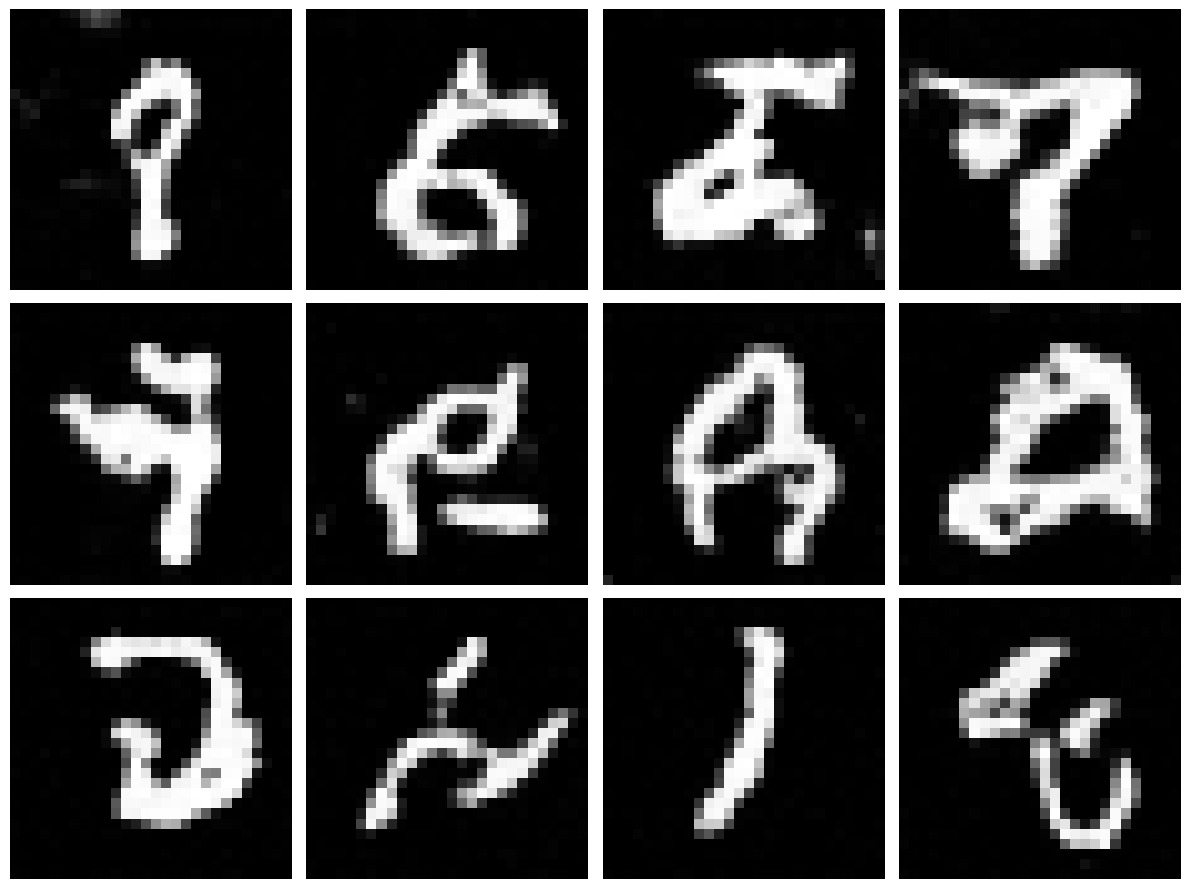


Timing Summary:
DDIM-50 (deterministic): 0.16s
DDIM-20 (deterministic): 0.04s
DDIM-50 (stochastic): 0.10s


In [11]:
fig, axes = plt.subplots(len(results), 4, figsize=(12, 3*len(results)))
for idx, (name, data) in enumerate(results.items()):
    samples = data['samples'].cpu()
    for i in range(4):
        ax = axes[idx, i] if len(results) > 1 else axes[i]
        img = (samples[i].squeeze() + 1) / 2
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_ylabel(name, fontsize=10, rotation=0, ha='right', va='center')
plt.tight_layout()
plt.show()

print('\nTiming Summary:')
for name, data in results.items():
    print(f'{name}: {data["time"]:.2f}s')

---

## 13. Demonstrating Consistency Property

**Key property**: Same $x_T$ → Same $x_0$ (when η=0)

In [12]:
# Helper function with fixed initial noise
@torch.no_grad()
def ddim_sample_fixed(model, x_init, sampling_timesteps=50, eta=0.0):
    device = next(model.parameters()).device
    batch_size = x_init.shape[0]
    step_size = 1000 // sampling_timesteps
    tau = torch.arange(0, 1000, step_size, device=device)
    tau = torch.cat([tau, torch.tensor([999], device=device)]).flip(0)
    x = x_init.clone()
    for i in range(len(tau)-1):
        t, s = tau[i], tau[i+1]
        alpha_bar_t = alphas_cumprod[t]
        alpha_bar_s = alphas_cumprod[s]
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)
        eps_theta = model(x, t_batch)
        x0_pred = (x - torch.sqrt(1 - alpha_bar_t) * eps_theta) / torch.sqrt(alpha_bar_t)
        sigma = eta * torch.sqrt((1 - alpha_bar_s) / (1 - alpha_bar_t)) * \
                torch.sqrt(1 - alpha_bar_t / alpha_bar_s)
        noise = torch.randn_like(x) if sigma > 0 else torch.zeros_like(x)
        x = torch.sqrt(alpha_bar_s) * x0_pred + \
            torch.sqrt(1 - alpha_bar_s - sigma**2) * eps_theta + sigma * noise
    return torch.clamp(x, -1, 1)

# Test consistency
torch.manual_seed(42)
x_T = torch.randn(1, 1, 28, 28, device=device)

print('Testing eta=0 (deterministic)...')
samples_det = [ddim_sample_fixed(model, x_T, eta=0.0) for _ in range(3)]
diff_01 = torch.abs(samples_det[0] - samples_det[1]).max().item()
diff_02 = torch.abs(samples_det[0] - samples_det[2]).max().item()
print(f'Max diff run1 vs run2: {diff_01:.6f}')
print(f'Max diff run1 vs run3: {diff_02:.6f}')
print('✅ Consistent!' if diff_01 < 1e-5 and diff_02 < 1e-5 else '❌ Not consistent')

print('\nTesting eta=1 (stochastic)...')
samples_stoch = [ddim_sample_fixed(model, x_T, eta=1.0) for _ in range(3)]
diff_01_s = torch.abs(samples_stoch[0] - samples_stoch[1]).max().item()
print(f'Max diff run1 vs run2: {diff_01_s:.6f}')
print('✅ Different!' if diff_01_s > 0.01 else '❌ Unexpectedly similar')

Testing eta=0 (deterministic)...
Max diff run1 vs run2: 0.000000
Max diff run1 vs run3: 0.000000
✅ Consistent!

Testing eta=1 (stochastic)...
Max diff run1 vs run2: 2.000000
✅ Different!


---

## 14. Latent Space Interpolation

Because DDIM is deterministic (η=0), we can interpolate meaningfully!

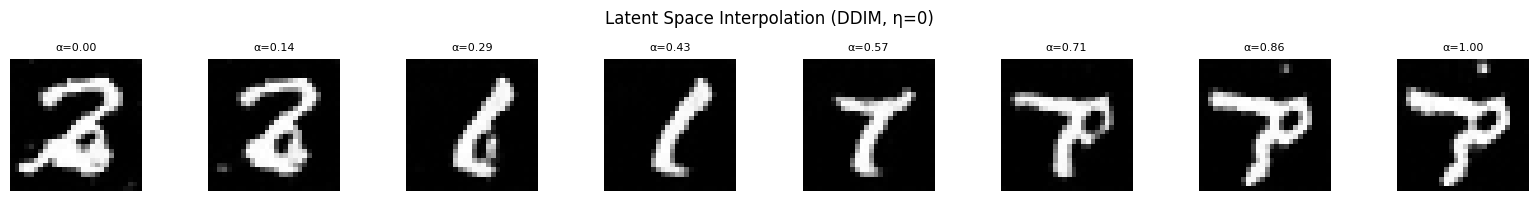

In [16]:
# Generate two latents
torch.manual_seed(32)
x_T_1 = torch.randn(1, 1, 28, 28, device=device)
torch.manual_seed(321)
x_T_2 = torch.randn(1, 1, 28, 28, device=device)

# Interpolate
n_steps = 8
alphas_interp = torch.linspace(0, 1, n_steps)
interpolated = []
for alpha in alphas_interp:
    x_T_interp = (1 - alpha) * x_T_1 + alpha * x_T_2
    sample = ddim_sample_fixed(model, x_T_interp, eta=0.0)
    interpolated.append(sample)

# Visualize
fig, axes = plt.subplots(1, n_steps, figsize=(16, 2))
for i, sample in enumerate(interpolated):
    img = (sample.cpu().squeeze() + 1) / 2
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'α={alphas_interp[i]:.2f}', fontsize=8)
plt.suptitle('Latent Space Interpolation (DDIM, η=0)')
plt.tight_layout()
plt.show()

---

## 15. Summary

### 🎯 Key Takeaways

1. **Non-Markovian Process**: DDIM conditions on $x_0$, enabling timestep skipping
2. **Same Training**: Uses identical $\mathcal{L}_{\text{simple}}$ as DDPM
3. **η Parameter**: Controls deterministic (η=0) vs stochastic (η=1)
4. **10-50x Speedup**: Use S=50 steps instead of T=1000
5. **Consistency**: Same $x_T$ → same $x_0$ when η=0

### 🚀 Practical Impact

- **Stable Diffusion**: Uses DDIM for fast sampling
- **Image Editing**: DDIM inversion enables real image editing
- **Interpolation**: Smooth transitions in latent space

### 💡 Key Equation

$$x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} \cdot \hat{x}_0 + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot \epsilon_\theta(x_t, t) + \sigma_t \epsilon_t$$

---

## 🎉 Congratulations!

You've implemented DDIM from scratch and understand:
- ✅ How non-Markovian processes enable acceleration
- ✅ Why training is identical to DDPM
- ✅ How to control stochasticity with η
- ✅ The power of deterministic sampling